> # TODO
> - Fix num_workers = 4
> - Bigger input size (480)

# Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import PIL
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("PyTorch Version: ",torchvision.__version__)

# plt.xkcd();  # commic plots plt.rcdefaults() to disable

PyTorch Version:  0.4.1
PyTorch Version:  0.2.1


# Hyperparameters

In [144]:
batch_size      = 32
val_percent     = 0.3
num_workers     = 4
num_classes     = 4

model           = "resnet18"
pretrained      = True
num_epochs      = 8
learning_rate   = 0.001
momentum        = 0.9
weight_decay    = 1e-4

gpu             = True
multiple_gpus   = False

# Load data

In [4]:
csv_file = pathlib.Path("D:/Datasets/TFM/histologyDS2828/imageClasses.txt")
data_dir = pathlib.Path("D:/Datasets/TFM/histologyDS2828/imgs")

In [133]:
class histologyDataset(Dataset):

	def __init__(self, csv_file, data_dir):
		self.labels      = pd.read_csv(csv_file, header=None, delim_whitespace=True)
		self.labels_map  = {1 : "conective tissue", 2 : "ephitelial tissue", 3 : "muscular tissue", 4 : "nervous tissue"};
		self.data_dir    = data_dir
		self.center_crop = transforms.CenterCrop(224) # 480
		self.random_crop = transforms.RandomCrop(224) # 480
		self.to_tensor   = transforms.ToTensor()

	def __len__(self):
		return len(self.labels)

	def __getitem__(self, idx):
		img_name = data_dir / (self.labels.iloc[idx, 0])
		image    = PIL.Image.open(img_name)
		image    = self.random_crop(image)
		image    = self.to_tensor(image)

		label = self.labels.iloc[idx, 1]

		return {"image": image, "label": label}
    
dataset    = histologyDataset(csv_file, data_dir)
#dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print("There are", len(dataset), "images in the dataset.")

There are 2828 images in the dataset.


# Check if data is balanced

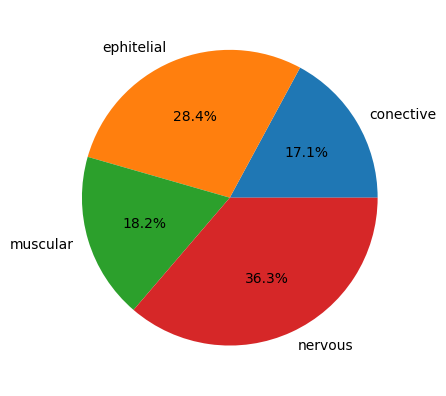

In [78]:
labels = 'conective', 'ephitelial', 'muscular', 'nervous'
count = [0, 0, 0, 0]

for i in range(len(dataset)):
	class_number = dataset.labels.iloc[i, 1]
	count[class_number-1] += 1

labels2 = [a+": "+str(b) for a, b in zip(labels, count)]
plt.pie(count, labels=labels, autopct='%1.1f%%');

# Show data

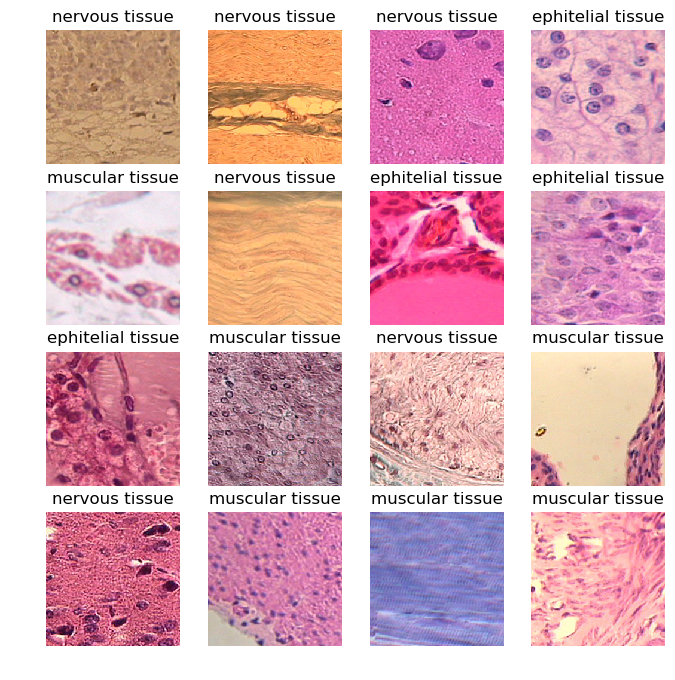

In [132]:
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 4;
for i in range(1, columns*rows +1):
    idx = np.random.randint(len(dataset));
    img = dataset[idx]["image"]
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    
    fig.add_subplot(rows, columns, i)
    
    plt.title(dataset.labels_map[dataset[idx]["label"]])
    plt.axis('off')
    plt.imshow(img)
plt.show()

# Model: Resnet

In [146]:
model = torchvision.models.resnet18(pretrained=True)
input_size = 224
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def freeze(model, freeze):
    if freeze:
        for param in model.parameters():
            param.requires_grad = False

# False: Finetune the whole model
# True:  Finetune the last layer
freeze(model, True)

model.fc   = nn.Linear(model.fc.in_features, num_classes) # new layer unfreezed by default


# Send the model to GPU
model = model.to(device)

print("Params to learn:")
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


# Train

In [147]:
# Optimizer
optimizer = optim.SGD(params_to_update, lr=learning_rate, momentum=0.9)
#optimizer = optim.Adam(params_to_update, lr=learning_rate);

# Loss function
criterion = nn.CrossEntropyLoss()

In [148]:
batch   = next(iter(dataloader))
inputs  = batch['image'].to(device)
classes = batch['label'].to(device)
print(inputs.size(), classes.size())

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [149]:
losses = [];
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    for i, batch in enumerate(dataloader):
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()             # zero the parameter gradients
        outputs = model(images)           # forward
        loss = criterion(outputs, labels) # loss
        loss.backward()                   # backward 
        optimizer.step()                  # optimize
        
        losses.append(loss.data[0]);
        
        if (i+1) % 10 == 0:
            print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(dataset)//batch_size, loss.data[0]))

Epoch 0/7
----------


C:\Users\Javi\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app
C:\Users\Javi\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch : 1/8, Iter : 10/88,  Loss: 1.5145
Epoch : 1/8, Iter : 20/88,  Loss: 1.2652
Epoch : 1/8, Iter : 30/88,  Loss: 1.3282
Epoch : 1/8, Iter : 40/88,  Loss: 1.1732
Epoch : 1/8, Iter : 50/88,  Loss: 1.3083
Epoch : 1/8, Iter : 60/88,  Loss: 1.0195
Epoch : 1/8, Iter : 70/88,  Loss: 1.1454
Epoch : 1/8, Iter : 80/88,  Loss: 1.1030
Epoch 1/7
----------
Epoch : 2/8, Iter : 10/88,  Loss: 1.1730
Epoch : 2/8, Iter : 20/88,  Loss: 1.0281
Epoch : 2/8, Iter : 30/88,  Loss: 1.1316
Epoch : 2/8, Iter : 40/88,  Loss: 1.1665
Epoch : 2/8, Iter : 50/88,  Loss: 1.3032
Epoch : 2/8, Iter : 60/88,  Loss: 1.1391
Epoch : 2/8, Iter : 70/88,  Loss: 1.1006
Epoch : 2/8, Iter : 80/88,  Loss: 0.8152
Epoch 2/7
----------
Epoch : 3/8, Iter : 10/88,  Loss: 1.0973
Epoch : 3/8, Iter : 20/88,  Loss: 0.9761
Epoch : 3/8, Iter : 30/88,  Loss: 1.1888
Epoch : 3/8, Iter : 40/88,  Loss: 0.8998
Epoch : 3/8, Iter : 50/88,  Loss: 0.9128
Epoch : 3/8, Iter : 60/88,  Loss: 0.9003
Epoch : 3/8, Iter : 70/88,  Loss: 0.9790
Epoch : 3/8, It